In [88]:
%matplotlib inline

import matplotlib.pyplot as pl
import seaborn as sb
import numpy as np

sb.set_context('notebook', font_scale=1.5)
blue, green, red, purple = sb.color_palette("deep",4)
yg0, yg1, yg2, yg3, yg4, yg5, yg6 = sb.color_palette("YlGn", 7)

## Why signal detection theory?

Numerous times, I have looked for signal detection theory (SDT) tutorials and illustrations online, but I have never been satisfied by what I've found. The [Wikipedia article](https://en.wikipedia.org/wiki/Detection_theory) is fine, but it would be better if it had some illustrations, and I think you need a decent amount of background to make much sense of it. So, here is the first (of an unknown, unplanned number) of Python notebooks about SDT.

My aim is to use both math and code to help the reader build up his or her intuitions about how SDT works and why it's useful. I would also like to enable the reader to actually *use* SDT productively in research. Please feel free to get in touch with any comments or criticisms.

### Some caveats

I will note at the outset that this will be my (possibly somewhat strange) take on SDT. I learned about SDT as a model of perception and response selection while I was learning about Bayesian statistical modeling, and the latter strongly informs how I think about the former.

I also note here that there is a lot of overlap between signal detection theory and (some parts of) statistical decision theory (e.g., the Neyman-Pearson null hypothesis significance testing framework). There is a also a lot of overlap with various various aspects of a lot of machine learning classifiers and statistical models. I will probably touch on these on occasion, but they won't be my focus.

### Some books

There are numerous books on SDT. I will borrow various bits and pieces from some of them. In particular, I will refer to Green & Swets (1966) *Signal Detection Theory and Psychophysics* and Wickens (2002) *Elementary Signal Detection Theory*. Some other books that may come up at some point: McNicols (2005) *A Primer of Signal Detection Theory*, Egan (1975) *Signal Detection Theory and ROC Analysis*, and MacMillan & Creelman (2005) *Detection Theory: A User's Guide*. I will also probably refer to journal articles here and there.

## The main point and a contrived example to illustrate it

Here's the very short, and vastly oversimplified, reason SDT is useful: it allows you to tease apart *sensitivity* (to a noisy signal) and *response bias*. It can be usefully applied to perception and memory, among a wide range of situations, some of which I'll delve into more deeply in the future. For this notebook, though, I will illustrate the basic concepts of SDT using the example from the first chapter of Green & Swets.

### A weird dice game

Suppose we're playing a game with three six-sided dice, two of which are normal, the other of which has three sides with 0 [pips](https://en.wikipedia.org/wiki/Pip_(counting)) and three sides with 3 pips. On each round of the game, I roll the three dice and tell you the total of the pips on all three, and your goal is to decide if the weird die showed 0 or 3 pips.

Your intution should be that, on average, the total will be larger when the weird die shows 3 than when it shows 0, but you may or may not have strong intuitions about the full distribution of possible outcomes. So, let's simulate a bunch of rounds of the game and visualize the results:

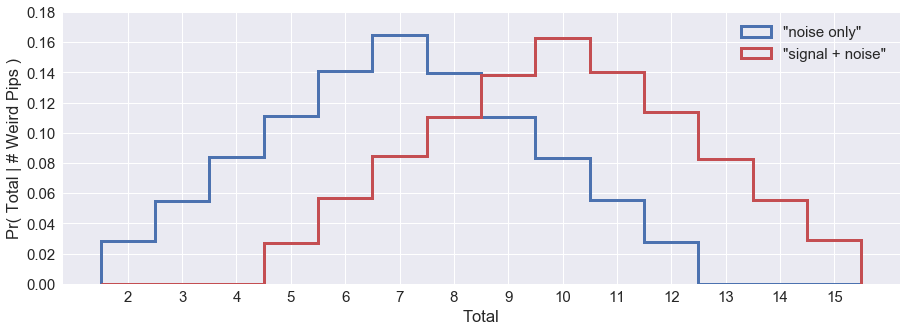

In [89]:
# get randint function to save a teeny bit of typing
randint = np.random.randint

# total number of simulations
n_sims = 100000

# simulated number of pips on the regular dice and the weird die and the total
reg_1 = randint(low=1, high=7, size=n_sims)
reg_2 = randint(low=1, high=7, size=n_sims)
weird = 3*randint(low=0, high=2, size=n_sims)
total = reg_1 + reg_2 + weird

# subset of totals for the noise (weird == 0) and signal (weird == 3) trials
tot_noise = total[weird == 0]
tot_signal = total[weird == 3]

# make histograms of the results
bins = np.arange(1.5,16.5)

fig, ax = pl.subplots(1,1,figsize=(15,5))
hn = ax.hist(tot_noise, bins=bins, histtype='step', color=blue, normed=True, lw=3)
hs = ax.hist(tot_signal, bins=bins, histtype='step', color=red, normed=True, lw=3)
ax.set(xticks=np.arange(2,16), xlabel="Total", yticks=np.arange(0,.2,.02), ylabel="Pr( Total | # Weird Pips )")
pn, bn, ln = hn; ps, bs, ls = hs
ax.legend([ln[0],ls[0]],['"noise only"','"signal + noise"']);

The blue line illustrates the distribution of totals for the trials in which the weird die showed 0 pips ("noise only"), and the red line illustrates the distribution of totals for the trials in which the weird die showed 3 pips ("signal + noise").

The figure as a whole illustrates the fact that there is a range of total values that can occur pretty frequently for either possible value of the weird die. So how should you choose your response (that the weird die showed 0 or 3)?

### Decision rules

If the total is 13 or more, or if it's 4 or less, it's easy, since only one state of the weird die can produce values in those ranges. But if the total is between 5 and 12 (inclusive), it is maybe not so obvious.

The figure contains a useful clue, though. Note that the relative heights of the two lines are never exactly equal - one state of the weird die is always more likely than the other to have produced a particular total. For example, suppose the total is 8. In the simulations above, the probability of observing 8 given that the weird die showed 0 is about 0.14, and the probability of observing 8 given that the weird die showed 3 is about 0.11.

Since a total of 8 is more likely when the weird die shows 0 than it is when the weird die shows 3, it makes some intuitive sense to respond "The weird die showed 0" when we observe a total of 8. We can generalize this specific case by using the *likelihood ratio* as a basis for our response.

#### The likelihood ratio

The likelihood ratio is $\displaystyle{\frac{\Pr(T=t|W=3)}{\Pr(T=t|W=0)}}$, where $T=t$ indicates the random possible total $T$ taking a specific value $t$, and $W$ indicates the random weird die value. Here's what the likelihood ratio looks like for the simulations above (for the ambiguous total values 5 through 12):

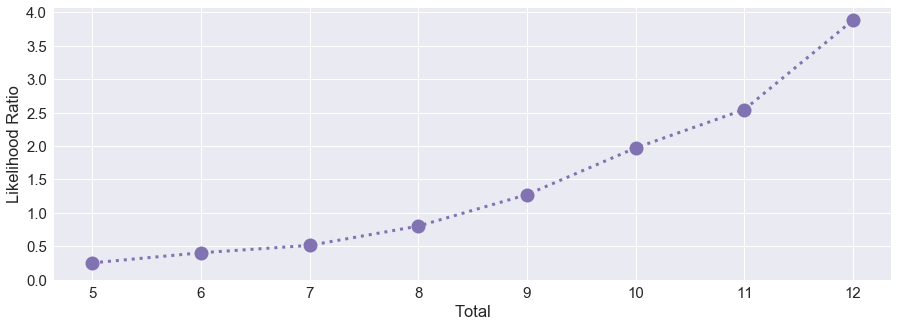

In [67]:
fig, ax = pl.subplots(1,1,figsize=(15,5))
ax.plot(bins[3:11]+0.5, ps[3:11]/pn[3:11], 'o:', lw=3, ms=14, color=purple)
ax.set(xlabel="Total", ylabel="Likelihood Ratio", yticks=np.arange(0,4.5,0.5));

For values up to 8, the total is more likely to have occurred when the weird die showed 0, so the likelihood ratio is less than 1. For values greater than 8, the total is more likely to have occurred when the weird die showed 3, so the likelihood ratio is greater than 1. This suggests a useful decision rule: Say "0" if the likelihood ratio is less than 1, and say "3" if the likelihood ratio is greater than 1. Or, equivalently, say "0" if the total is 8 or less, and say "3" if the total is 9 or more.

#### Bayes' rule

As it happens, this rule is equivalent to using [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem#Statement_of_theorem) and choosing the state of the weird die that is most probable given the observed total. The posterior probabilities of each state of the weird die given observed total $t$ are:

\begin{align}
\Pr(W=3|T=t) &= \frac{\Pr(T=t|W=3)\Pr(W=3)}{\Pr(T=t|W=0)\Pr(W=0) + \Pr(T=t|W=3)\Pr(W=3)}\\
&\\
\Pr(W=0|T=t) &= \frac{\Pr(T=t|W=0)\Pr(W=0)}{\Pr(T=t|W=0)\Pr(W=0) + \Pr(T=t|W=3)\Pr(W=3)}
\end{align}

We can state the Bayesian rule as: Say "3" if $\Pr(W=3|T=t) > \Pr(W=0|T=t)$, otherwise say "0."

Rearranging the posterior probability terms, this can be restated as: Say "3" if $\displaystyle{\frac{\Pr(W=3|T=t)}{\Pr(W=0|T=t)}} > 1$, otherwise say "0."

Because the denominators in the two equations above are the same, and because the prior probabilities are equal, i.e., $\Pr(W=0) = \Pr(W=3)$, the ratio of poterior probabilities is equal to the likelihood ratio: $\displaystyle{\frac{\Pr(W=3|T=t)}{\Pr(W=0|T=t)} = \frac{\Pr(T=t|W=3)}{\Pr(T=t|W=0)}}$.

Hence, for the situation so far, the Bayesian rule is just the likelihood ratio rule. We can easily add a response criterion based on this rule to the plot illustrating the distributions of "noise" and "signal + noise" totals. In the figure below, every total to the right of the criterion gets the response "3," and every total to the left of the criterion gets the response "0."

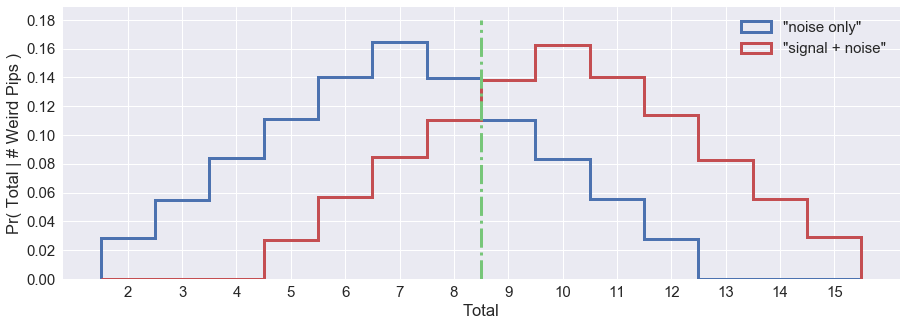

In [103]:
fig, ax = pl.subplots(1,1,figsize=(15,5))
hn = ax.hist(tot_noise, bins=bins, histtype='step', color=blue, normed=True, lw=3)
hs = ax.hist(tot_signal, bins=bins, histtype='step', color=red, normed=True, lw=3)
ax.plot([8.5,8.5], [0,0.18], '-.', color=yg3, lw=3)
ax.set(xticks=np.arange(2,16), xlabel="Total", yticks=np.arange(0,.2,.02), ylabel="Pr( Total | # Weird Pips )")
pn, bn, ln = hn; ps, bs, ls = hs
ax.legend([ln[0],ls[0]],['"noise only"','"signal + noise"']);

#### Unequal priors

The Bayesian formulation gives us a hint about how and why the simple likelihood ratio rule isn't the only option.

Suppose the weird die has just *two* sides with 0 pips and *four* sides with 3 pips. In this case, $\Pr(W=0) = \displaystyle{\frac{1}{3}}$ and $\Pr(W=3) = \displaystyle{\frac{2}{3}}$. With unequal priors, the Bayesian decision rule does not reduce to the rule based on comparing the likelihood ratio to 1.

Rather, the Bayesian rule is: Say "3" if $\displaystyle{\frac{\Pr(T=t|W=3)\Pr(W=3)}{\Pr(T=t|W=0)\Pr(W=0)}} > 1$, otherwise say "0."

This is equivalent to: Say "3" if $\displaystyle{\frac{\Pr(W=3|T=t)}{\Pr(W=0|T=t)} > \frac{\Pr(W=0)}{\Pr(W=3)}}$, otherwise say "0."

Hence, the Bayesian rule with unequal priors is equivalent to a rule comparing the likelihood ratio to the reciprocal of the ratio of the prior probabilities. In the case describe above, this new criterion is $\displaystyle{\frac{1/3}{2/3} = \frac{1}{2}}$.

Looking at the illustration of the likelihood ratio above, it looks like this rule should be to say "3" if the total is 7 or more, and to say "0" if the total is 6 or less. Looking at the totals and corresponding simulated likelihood ratio values confirms this:

In [77]:
print(bins[4:6]+0.5)
print(ps[4:6]/pn[4:6])

[ 6.  7.]
[ 0.40376769  0.51464143]


We can visualize this new criterion along with the original criterion based on equal priors:

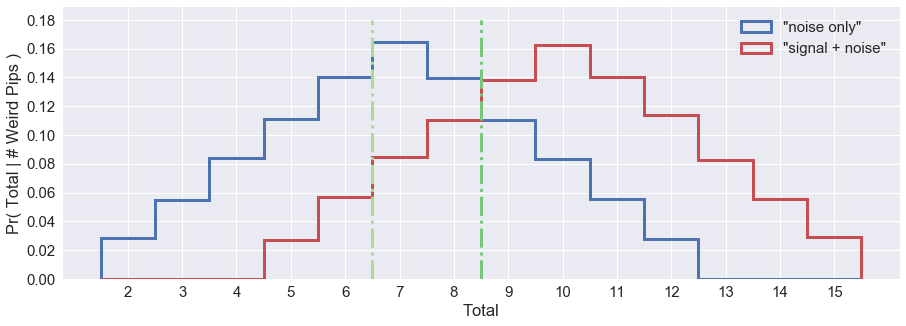

In [104]:
fig, ax = pl.subplots(1,1,figsize=(15,5))
hn = ax.hist(tot_noise, bins=bins, histtype='step', color=blue, normed=True, lw=3)
hs = ax.hist(tot_signal, bins=bins, histtype='step', color=red, normed=True, lw=3)
ax.plot([8.5,8.5], [0,0.18], '-.', color=yg3, lw=3)
ax.plot([6.5,6.5], [0,0.18], '-.', color=yg2, lw=3)
ax.set(xticks=np.arange(2,16), xlabel="Total", yticks=np.arange(0,.2,.02), ylabel="Pr( Total | # Weird Pips )")
pn, bn, ln = hn; ps, bs, ls = hs
ax.legend([ln[0],ls[0]],['"noise only"','"signal + noise"']);

And, of course, we can extend this reasoning to every possible (reciprocal) ratio of prior probabilities: $0$, $\displaystyle{\frac{1}{5}}$, $\displaystyle{\frac{1}{2}}$, $1$, $2$, $5$, and $\infty$. These correspond to rules to say "3" when the total is equal to or greater than 1, 5, 7, 9, 11, 13, and 16, otherwise "0."

(I'm playing a little bit fast and loose here, in that the most extreme cases - $\Pr(W=0)=0$ and $\Pr(W=0)=1$ - the total criterion could just as easily be any value less than 5 or greater than 12, respectively, since in the former, totals of 2, 3, and 4 will never occur, and in the latter, totals of 13, 14, and 15 will never occur.)

Plotting all of these criteria, we get:

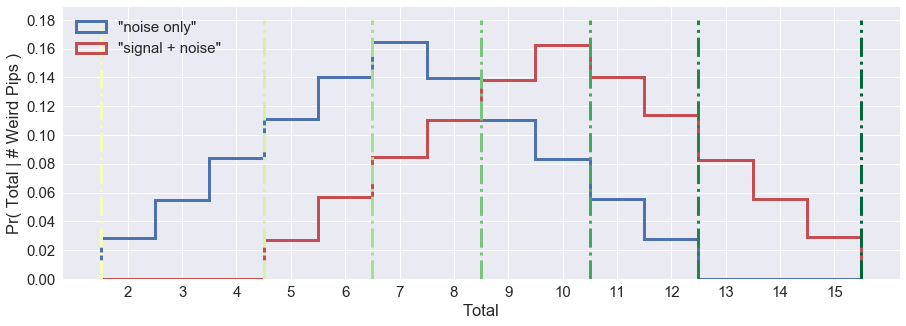

In [107]:
fig, ax = pl.subplots(1,1,figsize=(15,5))
hn = ax.hist(tot_noise, bins=bins, histtype='step', color=blue, normed=True, lw=3)
hs = ax.hist(tot_signal, bins=bins, histtype='step', color=red, normed=True, lw=3)
ygv = [yg0,yg1,yg2,yg3,yg4,yg5,yg6]; ctv = [1.5,4.5,6.5,8.5,10.5,12.5,15.5]
for yg, ct in zip(ygv,ctv):
    ax.plot([ct,ct], [0,0.18], '-.', color=yg, lw=3)
ax.set(xticks=np.arange(2,16), xlabel="Total", yticks=np.arange(0,.2,.02), ylabel="Pr( Total | # Weird Pips )")
pn, bn, ln = hn; ps, bs, ls = hs
ax.legend([ln[0],ls[0]],['"noise only"','"signal + noise"'], loc=2);

### Hits, false alarms, misses, and correct rejections

The distributions of totals for "noise" and "signal + noise" states and a particular decision rule combine to specify a confusion matrix. Here, rows correspond to the states of the weird die, and columns correspond to responses.

|     |         "W = 0"      |  "W = 3"     |
|-----|----------------------|--------------|
| W=0 |  Correct Rejection   |  False Alarm |
| W=3 |  Miss                |  Hit         |

The correct rejection rate is the probability of saying "0" when $W$ actually equals 0: $\Pr(\rm{"}W=0\rm{"}|W=0)$.

The False alarm rate is the probability of saying "3" when $W$ actually equals 0: $\Pr(\rm{"}W=3\rm{"}|W=0)$.

The miss rate is the probability of saying "0" when $W$ actually equal 3: $\Pr(\rm{"}W=0\rm{"}|W=3)$.

And the hit rate is the probability of saying "3" when $W$ actually equals 3: $\Pr(\rm{"}W=3\rm{"}|W=3)$.

Note that the hit rate is one minus the miss rate, and the false alarm rate is one minus the correct rejection rate. Put in moderately esoteric statistical terms, the matrix only has two degrees of freedom, one for each row. Once you know one of the numbers in a row, the other is determined.

Note, too, that there are a number of other quantities that can be computed from a 2 $\times$ 2 confusion matrix like this (e.g., positive predictive value, false discovery rate, etc..., see [this ugly but accurate table](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Confusion_matrix), for example, though note that the rows and columns are switched there, relative to how I have it here).

It's probably also worth keeping in mind that the hit rate is sometimes called "sensitivity," and the correct rejection rate is sometimes called "specificity." The former can be particularly confusing when you're dealing with SDT, since sensitivity means something very different in SDT (though the two are related). Speaking of which...

### Sensitivity and response bias

I wrote above that SDT is useful because it allows you to tease apart sensitivity (to a noisy signal) and response bias.

For each of the decision rules discussed above, the strength of the signal was held constant at 3 (in pip-count space). For a given signal strength, each decision rule produces a unique set of response probabilities. For example, in the figure above, the hit rate for a particular rule can be estimated as the area under the red curve to the right of the appropriate criterion. Similarly, the false alarm rate can be estimated as the area under the blue curve to the right of the same criterion. As the response criteria shift from left to right, both hit rates and false alarm rates decrease (though not, in general, at the same rate).

On the other hand, for a given decision rule, each signal strength produces a unique set of response probabilities. Suppose the weird die has three blank sides and three sides with *5* pips:

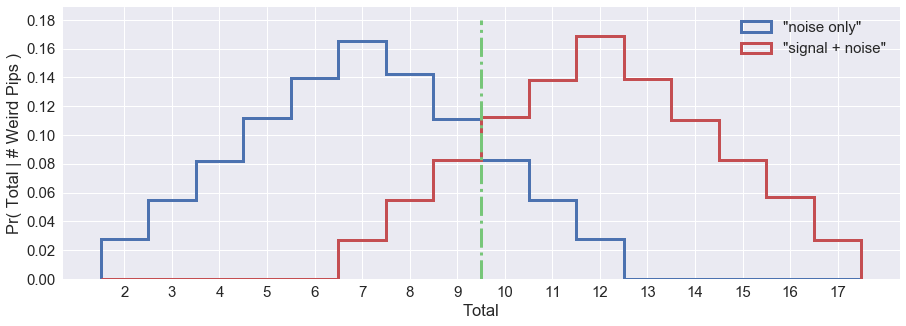

In [111]:
# simulated number of pips on the regular dice and the weird die and the total
reg_1 = randint(low=1, high=7, size=n_sims)
reg_2 = randint(low=1, high=7, size=n_sims)
weird = 5*randint(low=0, high=2, size=n_sims)
total = reg_1 + reg_2 + weird

# subset of totals for the noise (weird == 0) and signal (weird == 3) trials
tot_noise = total[weird == 0]
tot_signal = total[weird == 5]

# make histograms of the results
bins = np.arange(1.5,18.5)

# visualize it
fig, ax = pl.subplots(1,1,figsize=(15,5))
hn = ax.hist(tot_noise, bins=bins, histtype='step', color=blue, normed=True, lw=3)
hs = ax.hist(tot_signal, bins=bins, histtype='step', color=red, normed=True, lw=3)
ax.plot([9.5,9.5], [0,0.18], '-.', color=yg3, lw=3)
ax.set(xticks=np.arange(2,18), xlabel="Total", yticks=np.arange(0,.2,.02), ylabel="Pr( Total | # Weird Pips )")
pn, bn, ln = hn; ps, bs, ls = hs
ax.legend([ln[0],ls[0]],['"noise only"','"signal + noise"']);

With more signal strength, there is less overlap between the "noise" and "signal + noise" distributions, so the simple likelihood ratio decision rule produces higher hit rates and lower false alarm rates than the same rule in the case with a weaker signal.

A full account of a signal detection system must take all of this into account. The weird dice game example is meant primarily to illustrate the distinction between signal strength and decision rules. It also gives us a framework within which to introduce some useful terminology. But in typical uses of SDT, all we have is data generated by a signal detection system (i.e., hit rates, false alarm rates, etc...), and we want to draw inferences about the underlying properties of the system.

Of course, you can learn a lot about a system by looking just at hit rates and false alarm rates (or whichever values from each row of the confusion matrix you prefer). The beauty of SDT is that it allows you to use empirical hit and false alarm rates to estimate sensitivity (i.e., the displacement of the "signal + noise" distribution relative to the "noise only" distribution) and response bias (i.e., the criterion used to determine responses, which can be expressed in a number of different ways).

In the next notebook, I'll talk about more realistic situations in which we could use SDT to do this.